In [1]:
# import required packages

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf


/home/ssinghal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# display parent directory and working directory

print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/home/ssinghal/OneDrive/Documents/Graduate School/UT-Austin - MSIS: ['SDS 385 - Intro to Statistical Learning', 'INF 385M - Database Management', 'Data and Donuts', 'INF 385T - Information Security', 'Career Development Services', 'INF 397 - Statistical Analysis and Learning', 'GRA - UT Systems', 'SDS 358 - Applied Regression Analysis', 'INF 385E - Information Architecture and Design', 'INF 385T - Intro to Machine Learning', 'Capstone', 'INF 385T - Data Wrangling', 'CE 395R - Data Mining', 'Admin', 'Data Science Infographics', 'INF 385T - Tech Learning Studio', 'INF 380C - Information in Social and Cultural Context', 'ASIST', 'Applications', 'MIS 381N - User Generated Content Analytics', 'INF 397C - Understanding Research', 'INF 380E - Perspectives on Information', 'PSY 394U - Data Analytics with Python', 'INF 385C - Human Computer Interaction', 'GA - CSH Project', 'INF 385T - Intro to Blockchain', 'Course Selection', 'INF 385T - Programming for Cultural Data Analysis']
/home/ssinghal/

In [3]:
# split data in 80%/10%/10% train/validation/test sets

valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [4]:
# import stock prices data

df = pd.read_csv("bitcoin_cash_price.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, Feb 20, 2018 to Jul 23, 2017
Data columns (total 6 columns):
Open          213 non-null float64
High          213 non-null float64
Low           213 non-null float64
Close         213 non-null float64
Volume        213 non-null object
Market Cap    213 non-null object
dtypes: float64(4), object(2)
memory usage: 11.6+ KB


In [5]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Feb 20, 2018",1543.27,1569.03,1414.35,1418.73,"820,947,000","26,199,800,000"
"Feb 19, 2018",1483.34,1553.81,1483.34,1534.77,"578,906,000","25,179,700,000"
"Feb 18, 2018",1552.10,1641.40,1428.49,1487.46,"907,873,000","26,344,200,000"
"Feb 17, 2018",1548.48,1568.64,1517.14,1551.39,"641,719,000","26,280,100,000"
"Feb 16, 2018",1373.16,1558.66,1369.68,1552.20,"961,010,000","23,302,000,000"


In [6]:
df.tail()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 27, 2017",417.10,460.97,367.78,385.48,"533,207",-
"Jul 26, 2017",407.08,486.16,321.79,365.82,"1,784,640",-
"Jul 25, 2017",441.35,541.66,338.09,406.90,"524,908",-
"Jul 24, 2017",412.58,578.89,409.21,440.70,"190,952",-
"Jul 23, 2017",555.89,578.97,411.78,413.06,"85,013",-


In [7]:
df.describe()

,Open,High,Low,Close
count,213.000000,213.000000,213.000000,213.000000
mean,1103.532911,1199.696995,1014.952723,1106.705258
std,820.862352,892.000513,743.532709,819.384547
min,212.180000,223.700000,200.980000,213.150000
25%,420.470000,450.980000,395.740000,421.030000
50%,670.030000,756.930000,624.300000,690.240000
75%,1580.160000,1673.230000,1498.000000,1576.920000
max,3909.000000,4355.620000,3038.010000,3923.070000


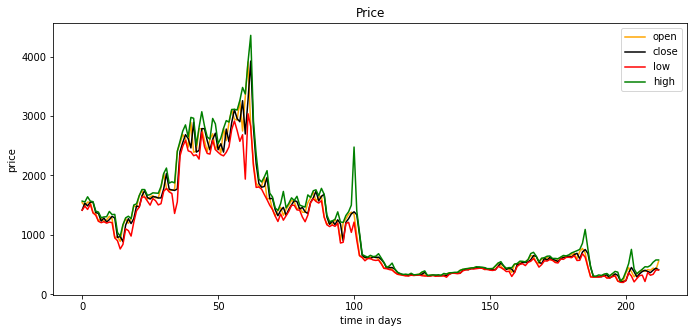

In [8]:
#Plotting Price metrics versus time

plt.figure(figsize=(25, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='orange', label='open')
plt.plot(df.Close.values, color='black', label='close')
plt.plot(df.Low.values, color='red', label='low')
plt.plot(df.High.values, color='green', label='high')
plt.title('Price')
plt.xlabel('time in days')
plt.ylabel('price')
plt.legend(loc='best')

plt.show()

In [9]:
# drop other columns
df.drop(['Volume'],1,inplace=True)
df.drop(['Market Cap'],1,inplace=True)

In [10]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    return df

In [11]:
# function to create train, validation, test data
def load_data(stock, seq_len):
    raw_data = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(raw_data) - seq_len): 
        data.append(raw_data[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [12]:
# normalize stock
df_norm = df.copy()
df_norm = normalize_data(df_norm)

In [13]:
# create train, test data
seq_len = 10 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (163, 9, 4)
y_train.shape =  (163, 4)
x_valid.shape =  (20, 9, 4)
y_valid.shape =  (20, 4)
x_test.shape =  (20, 9, 4)
y_test.shape =  (20, 4)


/home/ssinghal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


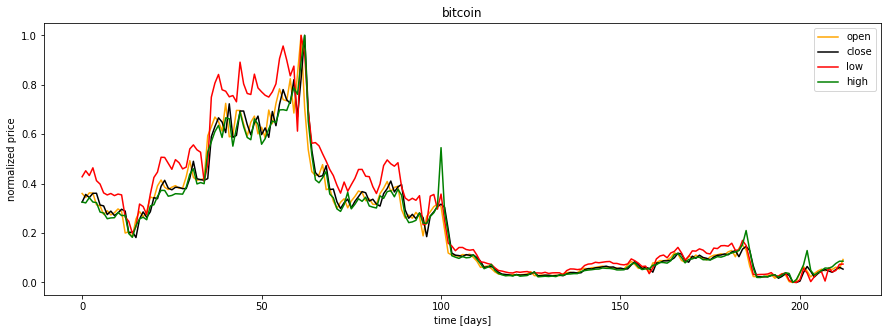

In [14]:
plt.figure(figsize=(15, 5));
plt.plot(df_norm.Open.values, color='orange', label='open')
plt.plot(df_norm.Close.values, color='black', label='close')
plt.plot(df_norm.Low.values, color='red', label='low')
plt.plot(df_norm.High.values, color='green', label='high')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')

plt.title('bitcoin')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

In [15]:
# prepare batches

index_in_epoch = 0;
permutation_array  = np.arange(x_train.shape[0])
np.random.shuffle(permutation_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(permutation_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[permutation_array[start:end]], y_train[permutation_array[start:end]]
    

In [16]:
## Model Run w/ Basic RNN

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.103348/0.028623
4.91 epochs: MSE train/valid = 0.007768/0.002278
9.82 epochs: MSE train/valid = 0.004172/0.001505
14.72 epochs: MSE train/valid = 0.002833/0.000806
19.63 epochs: MSE train/valid = 0.002311/0.000655
24.54 epochs: MSE train/valid = 0.002077/0.000659
29.45 epochs: MSE train/valid = 0.002373/0.000737
34.36 epochs: MSE train/valid = 0.001914/0.000479
39.26 epochs: MSE train/valid = 0.001808/0.000531
44.17 epochs: MSE train/valid = 0.001553/0.000440
49.08 epochs: MSE train/valid = 0.001707/0.000497
53.99 epochs: MSE train/valid = 0.001388/0.000363
58.90 epochs: MSE train/valid = 0.001334/0.000361
63.80 epochs: MSE train/valid = 0.001274/0.000352
68.71 epochs: MSE train/valid = 0.001307/0.000331
73.62 epochs: MSE train/valid = 0.001263/0.000368
78.53 epochs: MSE train/valid = 0.002107/0.000322
83.44 epochs: MSE train/valid = 0.001297/0.000296
88.34 epochs: MSE train/valid = 0.001192/0.000311
93.25 epochs: MSE train/valid = 0.001204/0.000350
98.

In [17]:
print(y_train.shape[0])
print(y_test.shape[0])

163
20


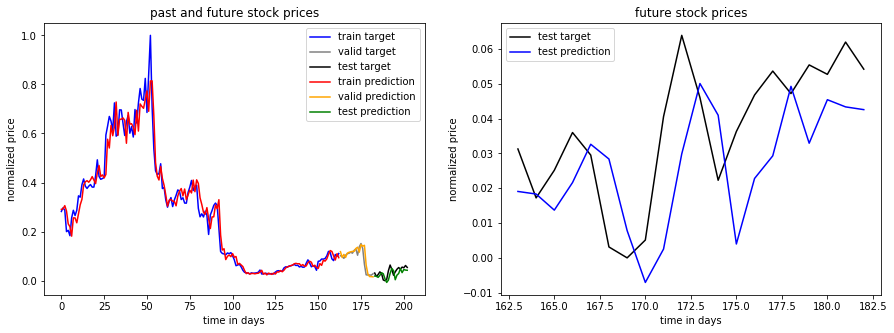

In [18]:
var = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,var], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,var],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,var], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,var], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,var], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,var], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time in days')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,var], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,var], color='blue', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time in days')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.show()

In [19]:
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]


print('correct classifiation of close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

correct classifiation of close - open price for train/valid/test: 0.63/0.60/0.60


In [20]:
## Model Run w/ Gated RNN, LSTM

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]


print('correct classifiation of close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

0.00 epochs: MSE train/valid = 0.111222/0.007627
4.91 epochs: MSE train/valid = 0.009751/0.004362
9.82 epochs: MSE train/valid = 0.007914/0.002339
14.72 epochs: MSE train/valid = 0.007077/0.001851
19.63 epochs: MSE train/valid = 0.006361/0.001824
24.54 epochs: MSE train/valid = 0.005511/0.001786
29.45 epochs: MSE train/valid = 0.004950/0.001841
34.36 epochs: MSE train/valid = 0.004539/0.001660
39.26 epochs: MSE train/valid = 0.004055/0.001540
44.17 epochs: MSE train/valid = 0.004492/0.001629
49.08 epochs: MSE train/valid = 0.003998/0.001413
53.99 epochs: MSE train/valid = 0.003797/0.001340
58.90 epochs: MSE train/valid = 0.003902/0.001175
63.80 epochs: MSE train/valid = 0.003535/0.001233
68.71 epochs: MSE train/valid = 0.003964/0.001418
73.62 epochs: MSE train/valid = 0.003394/0.001264
78.53 epochs: MSE train/valid = 0.003298/0.001173
83.44 epochs: MSE train/valid = 0.003204/0.001129
88.34 epochs: MSE train/valid = 0.003077/0.001136
93.25 epochs: MSE train/valid = 0.002898/0.001059
98.

In [21]:
# Optimize Hyper-paramters of Model


In [22]:
number_neurons=[]
corr_price_development_train_set=[]
corr_price_development_valid_set=[]
corr_price_development_test_set=[]

In [23]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Neurons (1)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 1
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_neurons.append(n_neurons)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [24]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Neurons (10)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 10
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_neurons.append(n_neurons)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [25]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Neurons (100)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 100
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_neurons.append(n_neurons)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [26]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Neurons (200)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_neurons.append(n_neurons)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [27]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Neurons (500)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 500
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_neurons.append(n_neurons)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [28]:
print(corr_price_development_test_set)

[0.35, 0.3, 0.6, 0.65, 0.6]


In [29]:
print(number_neurons)

[1, 10, 100, 200, 500]


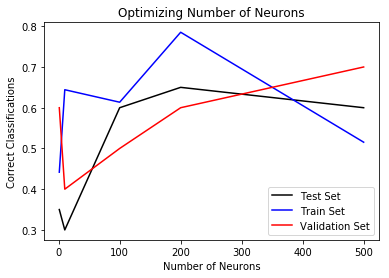

Optimal Number of Neurons: 200.000000
Highest correct classifiation of close - open price for test set: 0.650000000000000


In [30]:
# evaluate results

plt.plot(number_neurons,corr_price_development_test_set,color='black', label='Test Set')
plt.plot(number_neurons,corr_price_development_train_set,color='blue', label='Train Set')
plt.plot(number_neurons,corr_price_development_valid_set,color='red', label='Validation Set')
plt.legend()
plt.title('Optimizing Number of Neurons')
plt.xlabel('Number of Neurons')
plt.ylabel('Correct Classifications')

plt.show()

selected_value_neurons = max(corr_price_development_test_set)
selected_index = corr_price_development_test_set.index(selected_value_neurons)
selected_neurons = number_neurons[selected_index]

print('Optimal Number of Neurons: %1f'%(selected_neurons))
print('Highest correct classifiation of close - open price for test set: %.15f'%(selected_value_neurons))

In [31]:
number_layers=[]
corr_price_development_train_set=[]
corr_price_development_valid_set=[]
corr_price_development_test_set=[]

In [32]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Layers (1)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = 1
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_layers.append(n_layers)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [33]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Layers (2)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_layers.append(n_layers)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [34]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Layers (3)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = 3
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_layers.append(n_layers)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [35]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Layers (4)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = 4
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_layers.append(n_layers)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [36]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Layers (5)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = 5
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

number_layers.append(n_layers)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [37]:
print(corr_price_development_test_set)

[0.5, 0.6, 0.6, 0.6, 0.6]


In [38]:
print(number_layers)

[1, 2, 3, 4, 5]


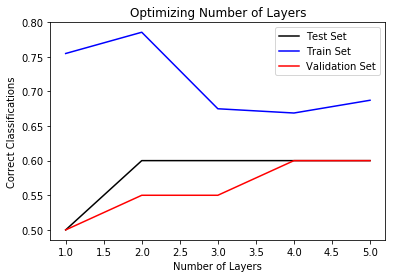

Optimal Number of Layers: 2.000000
Highest correct classifiation of close - open price for test set: 0.600000000000000


In [39]:
# evaluate results

plt.plot(number_layers,corr_price_development_test_set,color='black', label='Test Set')
plt.plot(number_layers,corr_price_development_train_set,color='blue', label='Train Set')
plt.plot(number_layers,corr_price_development_valid_set,color='red', label='Validation Set')
plt.legend()
plt.title('Optimizing Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Correct Classifications')

plt.show()

selected_value_layers = max(corr_price_development_test_set)
selected_index = corr_price_development_test_set.index(selected_value_layers)
selected_layers = number_layers[selected_index]

print('Optimal Number of Layers: %1f'%(selected_layers))
print('Highest correct classifiation of close - open price for test set: %.15f'%(selected_value_layers))

In [40]:
batch=[]
corr_price_development_train_set=[]
corr_price_development_valid_set=[]
corr_price_development_test_set=[]

In [41]:
## Model Run w/ Gated RNN, LSTM w/ Varying Batch Sizes (20)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = 20
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

batch.append(batch_size)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [42]:
## Model Run w/ Gated RNN, LSTM w/ Varying Batch Sizes (30)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = 30
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

batch.append(batch_size)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [43]:
## Model Run w/ Gated RNN, LSTM w/ Varying Batch Sizes (40)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = 40
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

batch.append(batch_size)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [44]:
## Model Run w/ Gated RNN, LSTM w/ Varying Batch Sizes (50)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

batch.append(batch_size)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [45]:
## Model Run w/ Gated RNN, LSTM w/ Varying Batch Sizes (60)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = 60
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

batch.append(batch_size)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [46]:
print(corr_price_development_test_set)

[0.6, 0.6, 0.6, 0.6, 0.6]


In [47]:
print(batch)

[20, 30, 40, 50, 60]


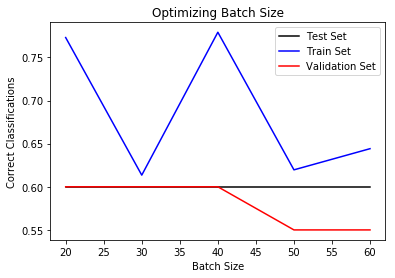

Optimal Number of Layers: 20.000000
Highest correct classifiation of close - open price for test set: 0.600000000000000


In [48]:
# evaluate results

plt.plot(batch,corr_price_development_test_set,color='black', label='Test Set')
plt.plot(batch,corr_price_development_train_set,color='blue', label='Train Set')
plt.plot(batch,corr_price_development_valid_set,color='red', label='Validation Set')
plt.legend()
plt.title('Optimizing Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Correct Classifications')

plt.show()

selected_value_batch = max(corr_price_development_test_set)
selected_index = corr_price_development_test_set.index(selected_value_batch)
selected_batch = batch[selected_index]

print('Optimal Number of Layers: %1f'%(selected_batch))
print('Highest correct classifiation of close - open price for test set: %.15f'%(selected_value_batch))

In [49]:
epochs=[]
corr_price_development_train_set=[]
corr_price_development_valid_set=[]
corr_price_development_test_set=[]

In [50]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Epochs (20)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

epochs.append(n_epochs)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [51]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Epochs (30)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = 30
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

epochs.append(n_epochs)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [52]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Epochs (70)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = 70
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

epochs.append(n_epochs)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [53]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Epochs (100)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

epochs.append(n_epochs)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [54]:
## Model Run w/ Gated RNN, LSTM w/ Varying Number of Epochs (200)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = 200
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

epochs.append(n_epochs)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [55]:
print(corr_price_development_test_set)

[0.6, 0.5, 0.6, 0.6, 0.55]


In [56]:
print(epochs)

[20, 30, 70, 100, 200]


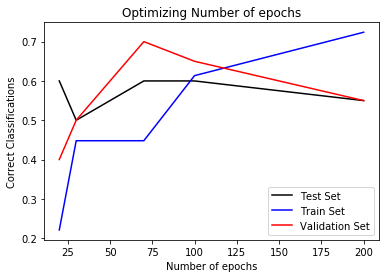

Optimal Number of Epochs: 20.000000
Highest correct classifiation of close - open price for test set: 0.600000000000000


In [57]:
# evaluate results

plt.plot(epochs,corr_price_development_test_set,color='black', label='Test Set')
plt.plot(epochs,corr_price_development_train_set,color='blue', label='Train Set')
plt.plot(epochs,corr_price_development_valid_set,color='red', label='Validation Set')
plt.legend()
plt.title('Optimizing Number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Correct Classifications')

plt.show()

selected_value_epoch = max(corr_price_development_test_set)
selected_index = corr_price_development_test_set.index(selected_value_epoch)
selected_epoch = epochs[selected_index]

print('Optimal Number of Epochs: %1f'%(selected_epoch))
print('Highest correct classifiation of close - open price for test set: %.15f'%(selected_value_epoch))

In [58]:
learn_rate=[]
corr_price_development_train_set=[]
corr_price_development_valid_set=[]
corr_price_development_test_set=[]

In [59]:
## Model Run w/ Gated RNN, LSTM w/ Varying Learning Rates (0.001)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.001
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

learn_rate.append(learning_rate)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [60]:
## Model Run w/ Gated RNN, LSTM w/ Varying Learning Rates (0.01)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.01
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

learn_rate.append(learning_rate)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [61]:
## Model Run w/ Gated RNN, LSTM w/ Varying Learning Rates (0.05)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.05
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

learn_rate.append(learning_rate)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [62]:
## Model Run w/ Gated RNN, LSTM w/ Varying Learning Rates (0.1)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.1
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

learn_rate.append(learning_rate)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [63]:
## Model Run w/ Gated RNN, LSTM w/ Varying Learning Rates (0.5)

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = 0.5
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# append results

learn_rate.append(learning_rate)
corr_price_development_train_set.append(corr_price_development_train)
corr_price_development_valid_set.append(corr_price_development_valid)
corr_price_development_test_set.append(corr_price_development_test)

In [64]:
print(corr_price_development_test_set)

[0.4, 0.55, 0.4, 0.35, 0.0]


In [65]:
print(learn_rate)

[0.001, 0.01, 0.05, 0.1, 0.5]


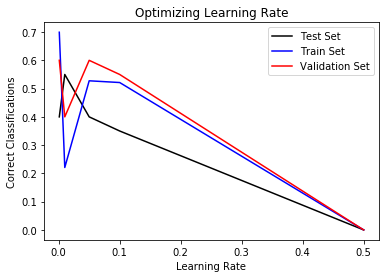

Optimal Learning Rate: 0.010000
Highest correct classifiation of close - open price for test set: 0.550000000000000


In [66]:
# evaluate results

plt.plot(learn_rate,corr_price_development_test_set,color='black', label='Test Set')
plt.plot(learn_rate,corr_price_development_train_set,color='blue', label='Train Set')
plt.plot(learn_rate,corr_price_development_valid_set,color='red', label='Validation Set')
plt.legend()
plt.title('Optimizing Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Correct Classifications')

plt.show()

selected_value_learn_rate = max(corr_price_development_test_set)
selected_index = corr_price_development_test_set.index(selected_value_learn_rate)
selected_learn_rate = learn_rate[selected_index]

print('Optimal Learning Rate: %1f'%(selected_learn_rate))
print('Highest correct classifiation of close - open price for test set: %.15f'%(selected_value_learn_rate))

In [67]:
# Optimized Model for Given Stock

In [68]:
## Model Run w/ Gated RNN, LSTM  - Optimized Hyper Parameters

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = selected_neurons
n_outputs = 4
n_layers = selected_layers
learning_rate = selected_learn_rate
batch_size = selected_batch
n_epochs = selected_epoch
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                   
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# classify into binary classes based on Close-Open predictions (gainers= +, lossers= -)

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('Final Model Classification Accuracy: %.15f'%(corr_price_development_test))

Final Model Classification Accuracy: 0.250000000000000


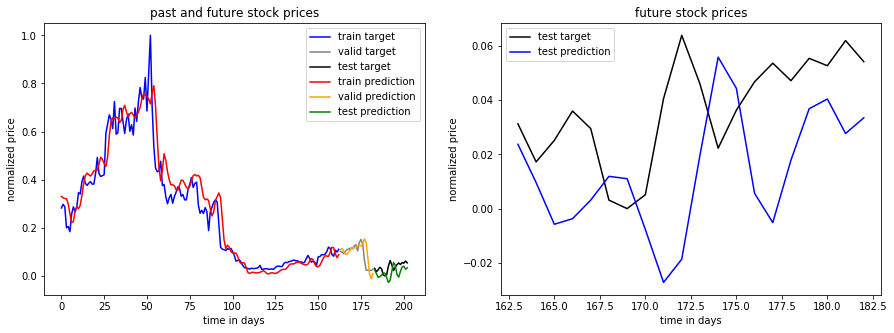

In [69]:
var = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,var], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,var],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,var], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,var], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,var], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,var], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time in days')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,var], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,var], color='blue', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time in days')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.show()